In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
import time
from dataloader import preprocess_data, construct_datasets

In [2]:
train_data = preprocess_data(pd.read_csv(r'..\dat\walks\random_walk_600min.csv'))
val_data = preprocess_data(pd.read_csv(r'..\dat\walks\random_walk_300min.csv'))
test_data = preprocess_data(pd.read_csv(r'..\dat\walks\random_walk_180min.csv'))

columns_input = ['finestep', 'step_diff', 'step_60rsum_exp', 'step_300rsum_exp', 'c_mean_lag10', 'c_mean_10rmean']

X_train, y_train, X_val, y_val, X_test, y_test = construct_datasets(train_data, val_data, test_data, columns_input)
X_train.head()

,finestep,step_diff,step_60rsum_exp,step_300rsum_exp,c_mean_lag10,c_mean_10rmean
600,0.502838,0.625000,0.538928,0.436671,0.456522,0.458696
601,0.503967,0.630952,0.541043,0.438384,0.457609,0.458478
602,0.505157,0.638889,0.543365,0.440162,0.457609,0.458696
603,0.506409,0.646825,0.545662,0.441987,0.460870,0.458261
604,0.507690,0.650794,0.547975,0.443800,0.457609,0.458370


In [4]:
def get_dataloader():
    # Load the FashionMNIST dataset.
    train_loader = torch.utils.data.DataLoader(
        TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)),
        batch_size=BATCHSIZE,
        shuffle=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        TensorDataset(torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32)),
        batch_size=BATCHSIZE,
        shuffle=False,
    )
    test_loader = torch.utils.data.DataLoader(
        TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)),
        batch_size=BATCHSIZE,
        shuffle=False,
    )
    return train_loader, valid_loader, test_loader

### Optuna

In [41]:
import os

import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms


DEVICE = torch.device("cuda")
BATCHSIZE = 128
CLASSES = 1
DIR = os.getcwd()
EPOCHS = 40
N_TRAIN_EXAMPLES = len(train_data) / BATCHSIZE
N_VALID_EXAMPLES = len(val_data) / BATCHSIZE


def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    #n_layers = trial.suggest_int("n_layers", 1, 2)
    n_layers = 1
    layers = []

    in_features = len(columns_input)
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 1, 10)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU())
        #p = trial.suggest_float("dropout_l{}".format(i), 0., 0.5)
        #layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LeakyReLU())
    return nn.Sequential(*layers)

def objective(trial):
    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    # optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    # lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    # optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Get the FashionMNIST dataset.
    train_loader, valid_loader, _ = get_dataloader()

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.mse_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        mse = 0
        mae = 0
        total_examples = 0

        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the loss
                mse += nn.MSELoss()(output, target).item()
                mae += nn.L1Loss()(output, target).item()
                total_examples += len(data)

        mse /= total_examples

        torch.save(model.state_dict(), f'./trials/model_trial_{trial.number}.pt')
        
        trial.report(mse, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return mse

def test(best_model, test_laoder):
    best_model.eval()
    mse = 0
    mae = 0

    predictions = []
    targets = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_laoder):
            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            output = best_model(data)
            mse += nn.MSELoss()(output, target).item()
            mae += nn.L1Loss()(output, target).item()
            predictions.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    
    mse /= len(predictions)
    mae /= len(predictions)
        
    return mse, mae, predictions, targets


In [42]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-29 17:26:46,626] A new study created in memory with name: no-name-6c8f43a3-a9a8-4997-bce8-06868209503c
[I 2024-05-29 17:26:49,533] Trial 0 finished with value: 7.043147692539523e-07 and parameters: {'n_units_l0': 6}. Best is trial 0 with value: 7.043147692539523e-07.
[I 2024-05-29 17:26:52,258] Trial 1 finished with value: 1.3858839648409313e-06 and parameters: {'n_units_l0': 10}. Best is trial 0 with value: 7.043147692539523e-07.
[I 2024-05-29 17:26:54,842] Trial 2 finished with value: 4.899151552318802e-07 and parameters: {'n_units_l0': 4}. Best is trial 2 with value: 4.899151552318802e-07.
[I 2024-05-29 17:26:57,577] Trial 3 finished with value: 0.0044523144394836645 and parameters: {'n_units_l0': 1}. Best is trial 2 with value: 4.899151552318802e-07.
[I 2024-05-29 17:27:00,244] Trial 4 finished with value: 4.288996354840823e-07 and parameters: {'n_units_l0': 7}. Best is trial 4 with value: 4.288996354840823e-07.
[I 2024-05-29 17:27:00,323] Trial 5 pruned. 
[I 2024-05-29 

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  192
  Number of complete trials:  8
Best trial:
  Value:  1.4024206119632832e-07
  Params: 
    n_units_l0: 10


In [43]:
optuna_model = define_model(trial).to(DEVICE)
optuna_model.load_state_dict(torch.load(f'./trials/model_trial_{trial.number}.pt'))
train_loader, val_loader, test_loader = get_dataloader()

optuna_model

Sequential(
  (0): Linear(in_features=6, out_features=10, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=10, out_features=1, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
)

Test MSE: 3.4243975729644126e-07, Test MAE: 3.3921167080032104e-05


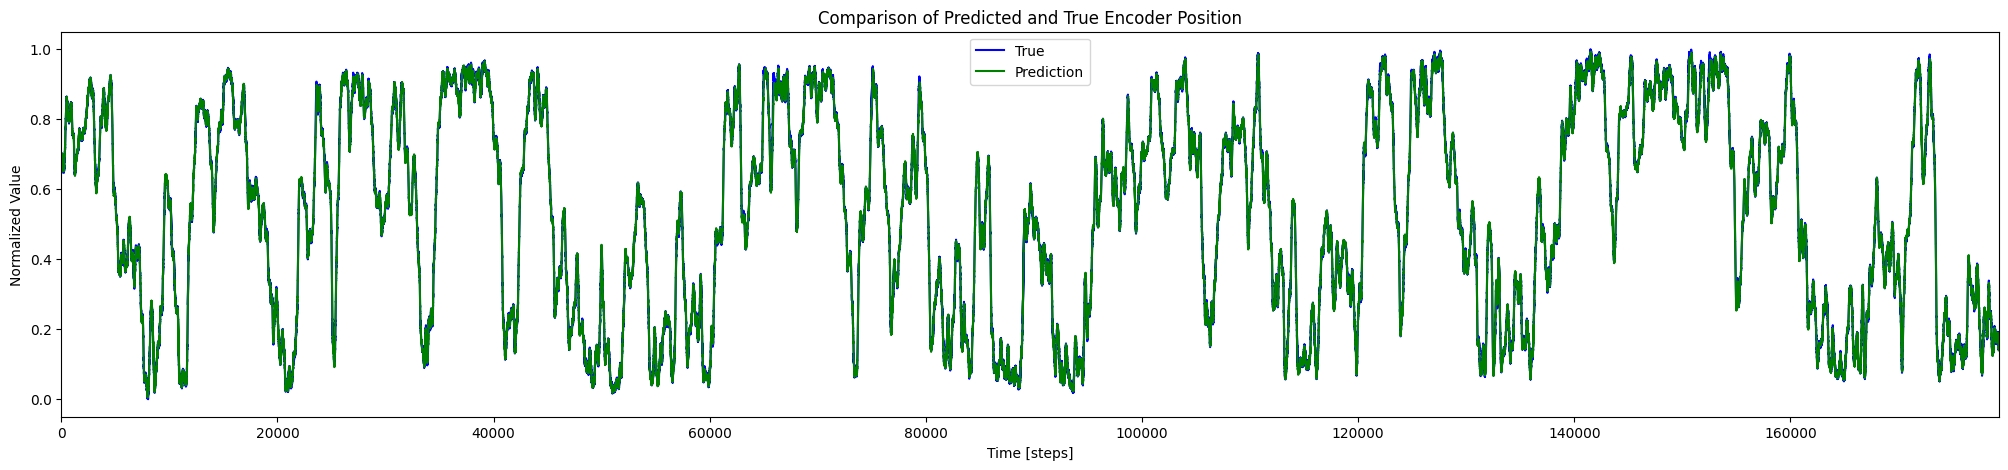

In [44]:
mse, mae, predictions, targets = test(optuna_model, val_loader)
print(f"Test MSE: {mse}, Test MAE: {mae}")
# Plotting the results
plt.figure(figsize=(25, 5))
plt.plot(targets, label='True', color='blue')
plt.plot(predictions, label='Prediction', color='green')
plt.xlim(0, len(targets))
plt.title('Comparison of Predicted and True Encoder Position')
plt.xlabel('Time [steps]')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

In [67]:
criterion = nn.MSELoss()
optimizer = optim.Adam(optuna_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 35], gamma=0.1)

train_losses = []
val_losses = []
model = define_model(trial).to(DEVICE)
best_loss = 1
# Training loop
num_epochs = 45
for epoch in range(num_epochs):
    optuna_model.train()
    train_losses.append(0)
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = optuna_model(inputs.to('cuda'))
        loss = criterion(outputs.to('cpu'), targets)
        loss.backward()
        optimizer.step()
        train_losses[-1] += loss.item()
    train_losses[-1] /= len(train_loader)

    val_losses.append(0)
    for inputs, targets in val_loader:
        outputs = optuna_model(inputs.to('cuda'))
        loss = criterion(outputs.to('cpu'), targets)
        val_losses[-1] += loss.item()
    val_losses[-1] /= len(val_loader)
    if val_losses[-1] < best_loss:
        best_loss = val_losses[-1]
        torch.save(optuna_model.state_dict(), f'./final/optuna_model.pth')
        torch.save(optuna_model, f'./final/optuna_model_full.pth')
        print(f'Saved best model at epoch {epoch}')

    #scheduler.step()
    # Optionally print the loss every few epochs
    if (epoch) % 10 == 0:
        print(f'Epoch {epoch} \t Train loss: {train_losses[-1]} \t Validation loss: {val_losses[-1]}')

    optuna_model.load_state_dict(torch.load(f'./final/optuna_model.pth'))

Saved best model at epoch 0
Epoch 0 	 Train loss: 1.0034733368508002e-05 	 Validation loss: 9.81457816428484e-06
Saved best model at epoch 1
Saved best model at epoch 3
Saved best model at epoch 4
Epoch 10 	 Train loss: 9.994662652157455e-06 	 Validation loss: 9.470908268624205e-06
Epoch 20 	 Train loss: 1.00131833584472e-05 	 Validation loss: 1.043295926071728e-05
Epoch 30 	 Train loss: 1.0047834921089302e-05 	 Validation loss: 9.343944386402044e-06
Epoch 40 	 Train loss: 9.996464803596655e-06 	 Validation loss: 9.841702803461676e-06


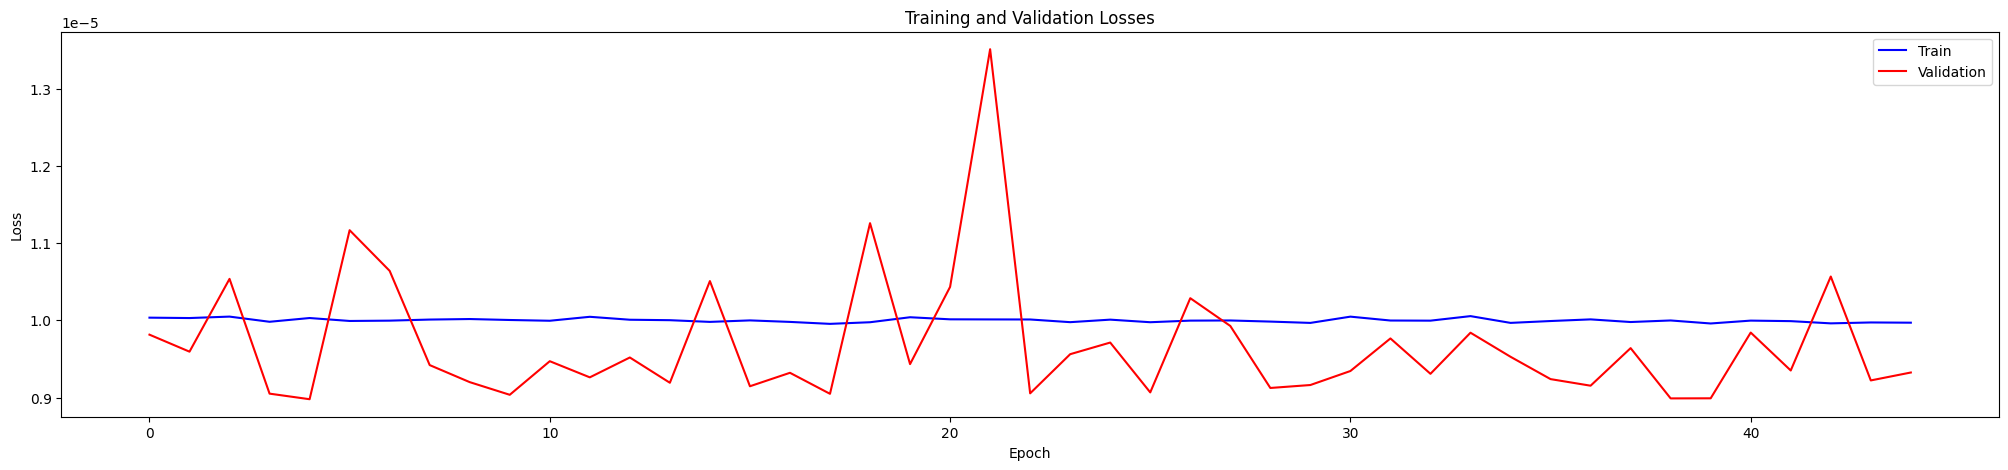

In [81]:
plt.figure(figsize=(25, 5))
plt.plot(train_losses, label='Train', color='blue')
plt.plot(val_losses, label='Validation', color='red')
plt.legend(lines + lines2, labels + labels2)
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
optuna_model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    mse = 0
    for inputs, targets in test_loader:
        outputs = optuna_model(inputs.to('cuda'))
        loss = criterion(outputs.to('cpu'), targets)
        mse += loss.item()
        all_predictions.extend(outputs.view(-1).tolist())
        all_targets.extend(targets.view(-1).tolist())
    mse /= len(test_loader)
    print(f'Test Loss: {mse:.8f}')

Test Loss: 0.00000984


Test MSE: 7.69783441036597e-08, Test MAE: 1.9325990155279236e-05


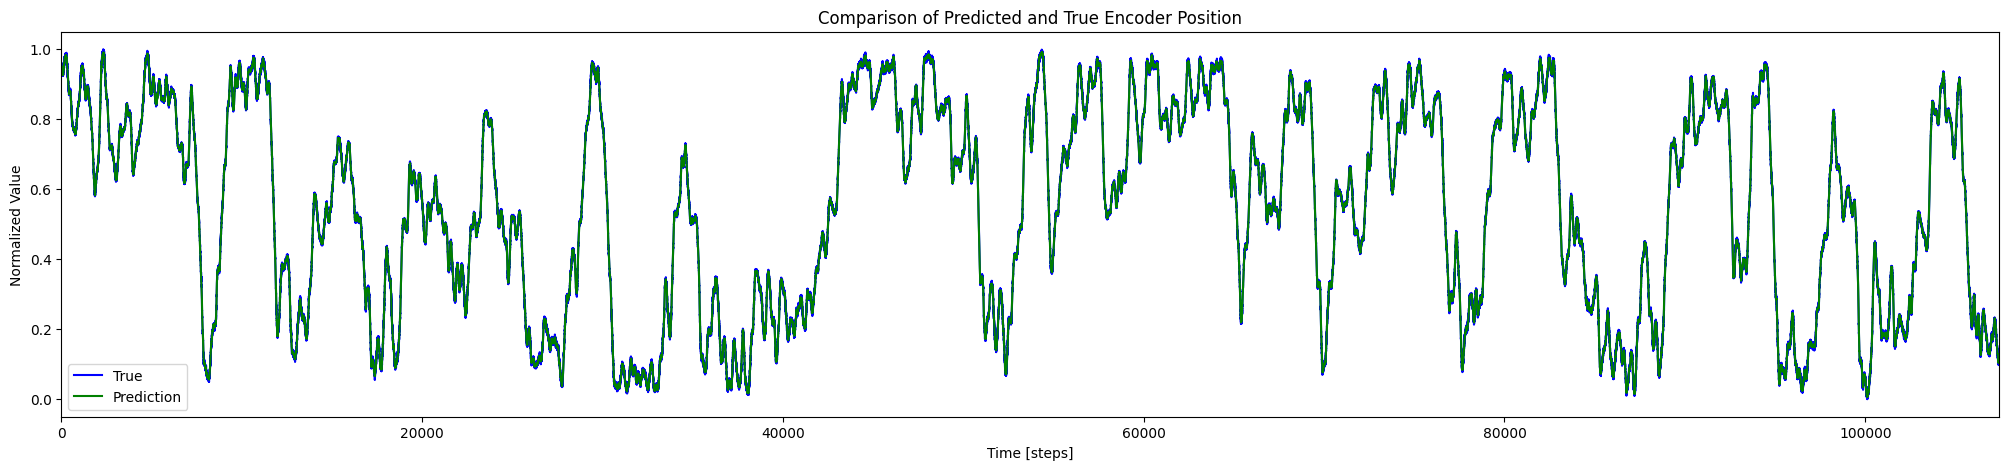

In [83]:
_, val_loader, test_loader = get_dataloader()
mse, mae, predictions, targets = test(optuna_model, test_loader)
print(f"Test MSE: {mse}, Test MAE: {mae}")
# Plotting the results
plt.figure(figsize=(25, 5))
plt.plot(targets, label='True', color='blue')
plt.plot(predictions, label='Prediction', color='green')
plt.xlim(0, len(targets))
plt.title('Comparison of Predicted and True Encoder Position')
plt.xlabel('Time [steps]')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

### Create Model

In [3]:
# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(len(columns_input), 10)
        #self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        #x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Train Model

In [9]:
train_loader, val_loader, test_loader = get_dataloader()

own_model = SimpleNN().to('cuda')
own_model

# Initialize the model, loss function, and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(own_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8, 16], gamma=0.1)

train_losses = []
val_losses = []

# Training loop
num_epochs = 40
for epoch in range(num_epochs):
    own_model.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = own_model(inputs.to('cuda'))
        loss = criterion(outputs.to('cpu'), targets)
        loss.backward()
        total_train_loss += loss.item()
        optimizer.step()
    scheduler.step()
    train_losses.append(total_train_loss)

    own_model.eval()
    total_val_loss = 0
    for inputs, targets in val_loader:
        outputs = own_model(inputs.to('cuda'))
        loss = criterion(outputs.to('cpu'), targets)
        total_val_loss += loss.item()
    val_losses.append(total_val_loss)

    # Optionally print the loss every few epochs
    if (epoch) % 5 == 0:
        print(f'Epoch {epoch} \t Train Loss: {loss.item():.8f} \t Val Loss: {total_val_loss:.8f}')

torch.save(own_model.state_dict(), f'./final/simple_nn.pth')

own_model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    mse = 0
    for inputs, targets in test_loader:
        outputs = own_model(inputs.to('cuda'))
        loss = criterion(outputs.to('cpu'), targets)
        mse += loss.item()
        all_predictions.extend(outputs.view(-1).tolist())
        all_targets.extend(targets.view(-1).tolist())
    print(f'Test Loss: {mse:.8f}')

NameError: name 'get_dataloader' is not defined

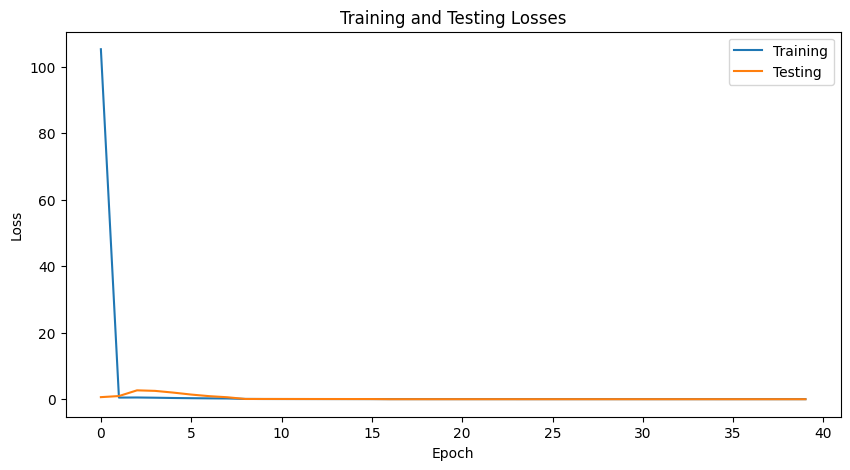

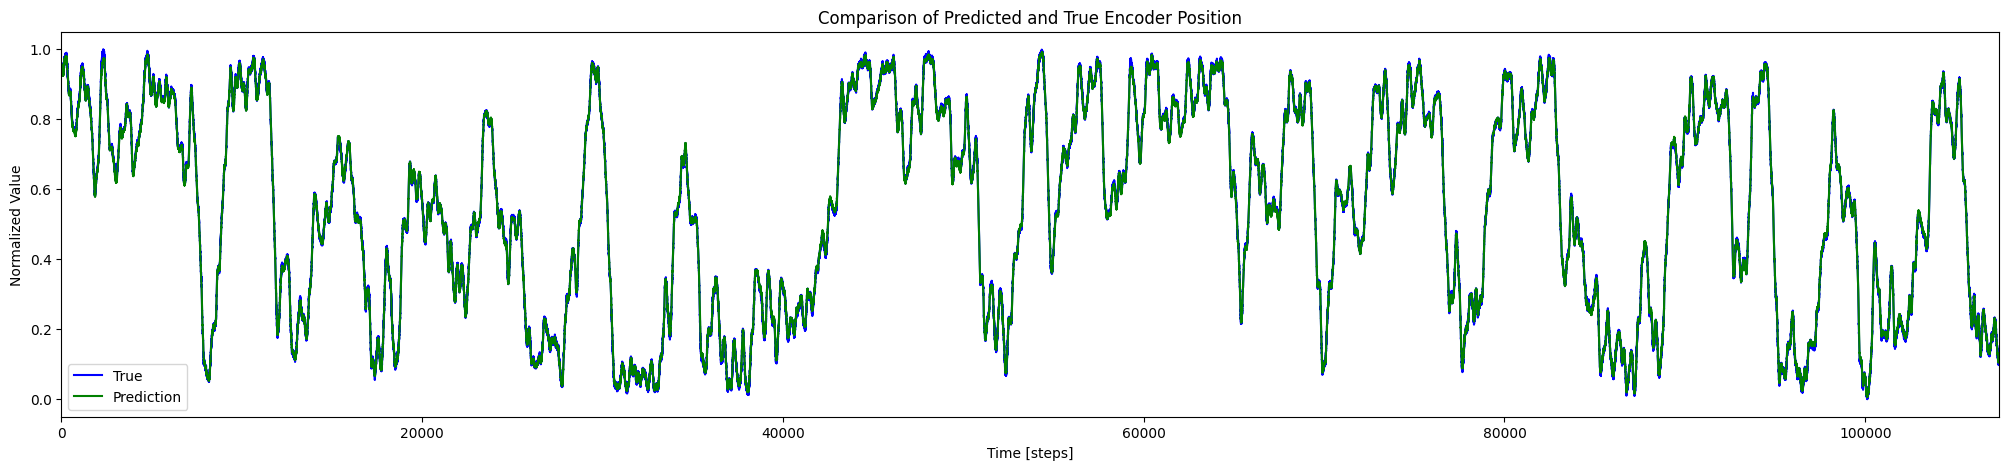

In [28]:
# Plot the training and testing losses
plt.figure(figsize=(10, 5))
plt.title('Training and Testing Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Testing ')
plt.legend()
plt.show()

# Plotting the results
plt.figure(figsize=(25, 5))
plt.plot(all_targets, label='True', color='blue')
plt.plot(all_predictions, label='Prediction', color='green')
plt.xlim(0, len(all_targets))
plt.title('Comparison of Predicted and True Encoder Position')
plt.xlabel('Time [steps]')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

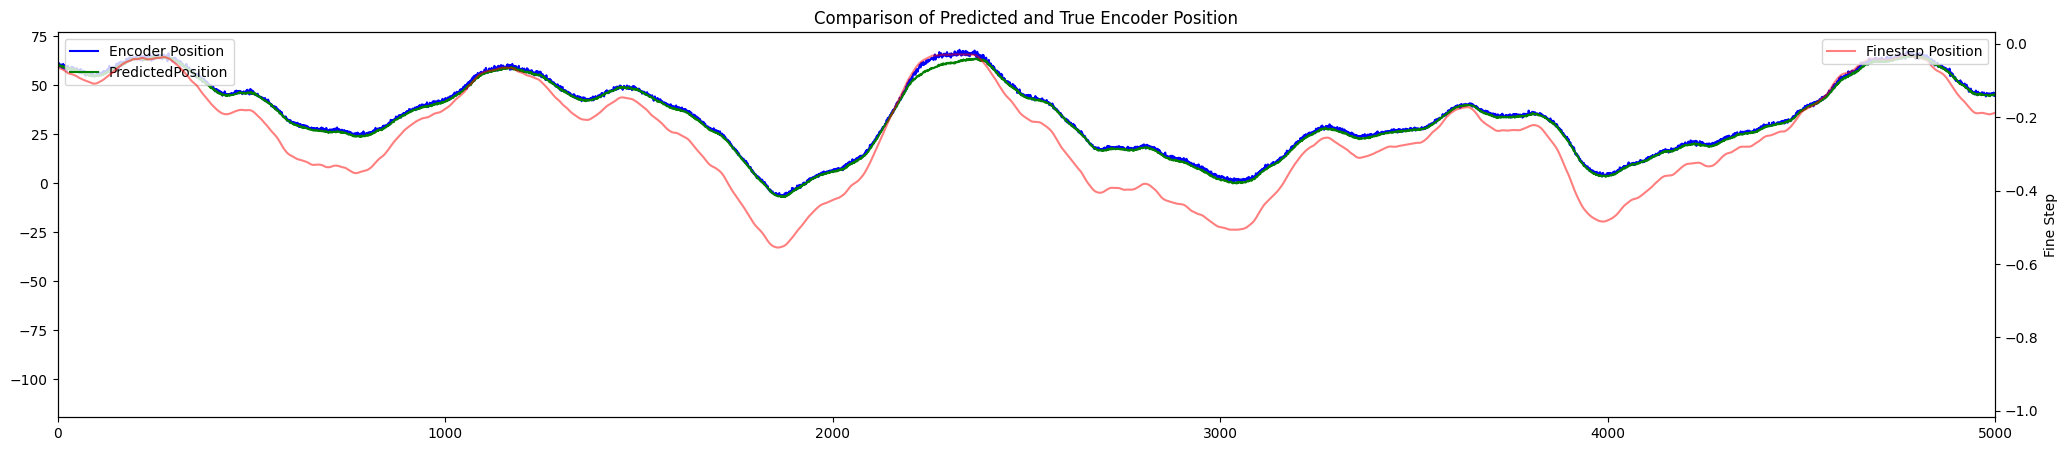

In [37]:
all_predictions_unnorm = np.array(all_predictions) * (test_data['c_mean_unnorm'].max() - test_data['c_mean_unnorm'].min()) + test_data['c_mean_unnorm'].min()
plt.figure(figsize=(25, 5))
plt.plot(test_data['c_mean_unnorm'], label='Encoder Position', color='blue')
plt.plot(all_predictions_unnorm, label='PredictedPosition', color='green')
plt.legend(loc='upper left')
#plt.ylim(0.5, 1)

plt.ax2 = plt.twinx()
plt.ax2.plot(-test_data['finestep'], label='Finestep Position', color='red', alpha=0.5)
plt.title('Comparison of Predicted and True Encoder Position')
plt.xlim(0, 5000)
#plt.ylim(-np.power(2, 15), np.power(2, 15))
# label secondary y-axis as 'FInesteo'
plt.ax2.set_ylabel('Fine Step')
plt.legend(loc='upper right')
plt.show()

### Load Model

In [4]:
# laod the state dict
columns_input = ['finestep', 'step_diff', 'step_60rsum_exp', 'step_300rsum_exp', 'c_mean_lag10', 'c_mean_10rmean']
model = SimpleNN().to('cuda')
model.load_state_dict(torch.load(r'./final/simple_nn.pth'))
model

SimpleNN(
  (fc1): Linear(in_features=6, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

### Evaluate for Creep

In [5]:
creep_data = preprocess_data(pd.read_csv(r'..\dat\creep\random_walk_30min_pause30at30min_15.csv'))
# if os.path.exists(r'..\dat\predictions\random_walk_30min_pause30at30min_15.csv'):
#     results = preprocess_data(pd.read_csv(r'..\dat\creep\random_walk_30min_pause30at30min_15.csv'))
# else:
#     results = creep_data.copy()

# only take every 30th row
# test_df = test_df.iloc[::100, :]
# test_df = test_df.reset_index(drop=True)

In [8]:
model.eval()

outputs = []
gt = []
mse = 0
with torch.no_grad():
    for index, row in creep_data.loc[:].iterrows():
        if len(outputs) > 17000:
            row['c_mean_lag1'] = outputs[-1]
            row['c_mean_60rmean'] = (row['c_mean_60rmean'] * 60 - row['c_mean'] + outputs[-1]) / 60
            row['c_mean_10rmean'] = (row['c_mean_10rmean'] * 10 - row['c_mean'] + outputs[-1]) / 10
            if len(outputs) > 17004:
                row['c_mean_lag5'] = outputs[-5]
            if len(outputs) > 17009:
                row['c_mean_lag10'] = outputs[-10]
            if len(outputs) > 17049:
                row['c_mean_lag50'] = outputs[-50]

        inputs = torch.tensor(row[columns_input].values, dtype=torch.float32).view(1, -1)
        output = model(inputs.to('cuda'))
        outputs.append(output.to('cpu').item())
        gt.append(row['c_mean'])

mae = np.mean(np.abs(np.array(outputs) - np.array(gt)))
print(f'MAE: {mae}')
mse = np.mean(np.square(np.array(outputs) - np.array(gt)))
print(f'MSE: {mse}')

MAE: 0.0034891618290109967
MSE: 1.9161374366258413e-05


In [20]:
results['network'] = outputs
pd.DataFrame(results).to_csv(r'..\dat\predictions\random_walk_30min_pause30at30min_15.csv', index=False)

NameError: name 'outputs' is not defined

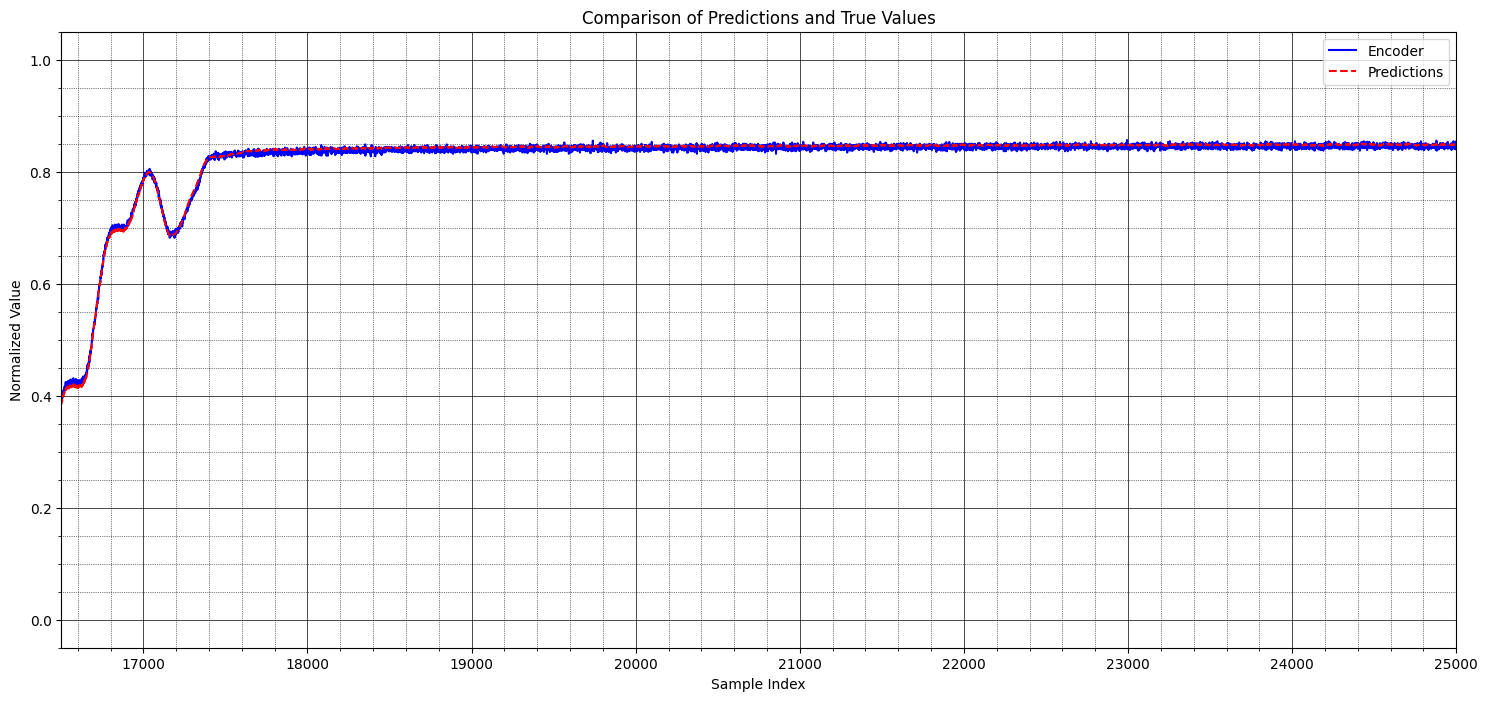

In [11]:
plt.figure(figsize=(18, 8))
plt.plot(gt, label='Encoder', color='blue')
plt.plot(outputs, label='Predictions', color='red', linestyle='dashed')
plt.title('Comparison of Predictions and True Values')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Value')
plt.xlim(16500, 25000)
#plt.ylim(0, 50)
# create grid with minor ticks on y-axis
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.legend()
plt.show()

In [22]:
outputs_unnorm = np.array(outputs) * (creep_data['c_mean_unnorm'].max() - creep_data['c_mean_unnorm'].min()) + creep_data['c_mean_unnorm'].min()
gt_roll = creep_data['c_mean_unnorm'].rolling(window=60).mean()

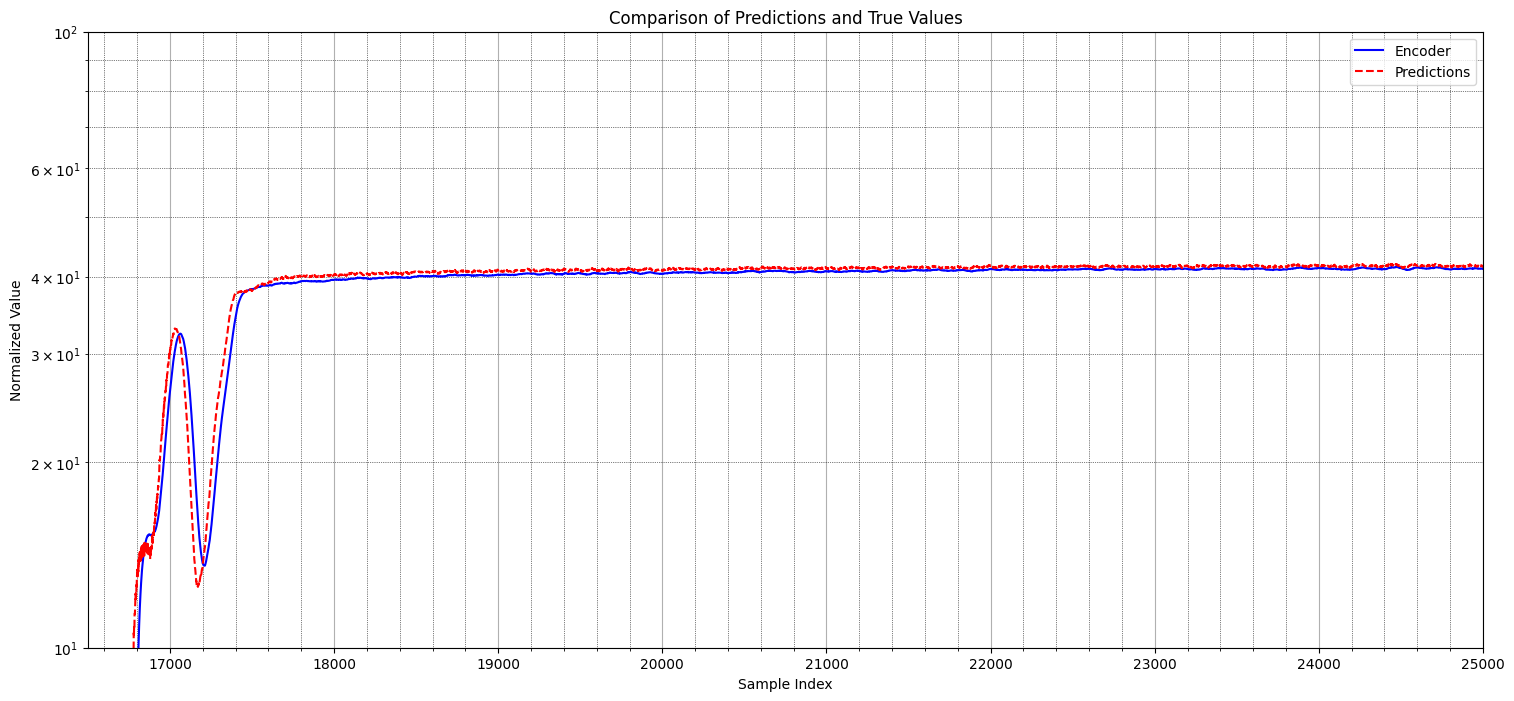

In [23]:
# Plotting the results
plt.figure(figsize=(18, 8))
plt.plot(gt_roll, label='Encoder', color='blue')
plt.plot(outputs_unnorm, label='Predictions', color='red', linestyle='dashed')
plt.title('Comparison of Predictions and True Values')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Value')
plt.xlim(16500, 25000)
#plt.ylim(0, 50)
plt.grid()
# add minor ticks every 2
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# make the y axis log scale
plt.yscale('log')
plt.ylim(10, 100)
#plt.grid(which='both')

plt.legend()
plt.show()

### Evaluate hysteresis prediction

In [38]:
model.eval()

outputs = model(torch.tensor(test_data[columns_input].values, dtype=torch.float32).to('cuda')).to('cpu').detach().numpy()

mae = np.mean(np.abs(outputs.flatten() - test_data['c_mean'].values))
print(f'MAE: {mae}')

MAE: 0.003656599942704907


In [28]:
if os.path.exists(r'..\dat\predictions\random_walk_180min.csv'):
    results = preprocess_data(pd.read_csv(r'..\dat\predictions\random_walk_180min.csv'))
else:
    results = test_data.copy()

results['network'] = outputs
pd.DataFrame(results).to_csv(r'..\dat\predictions\random_walk_180min.csv', index=False)

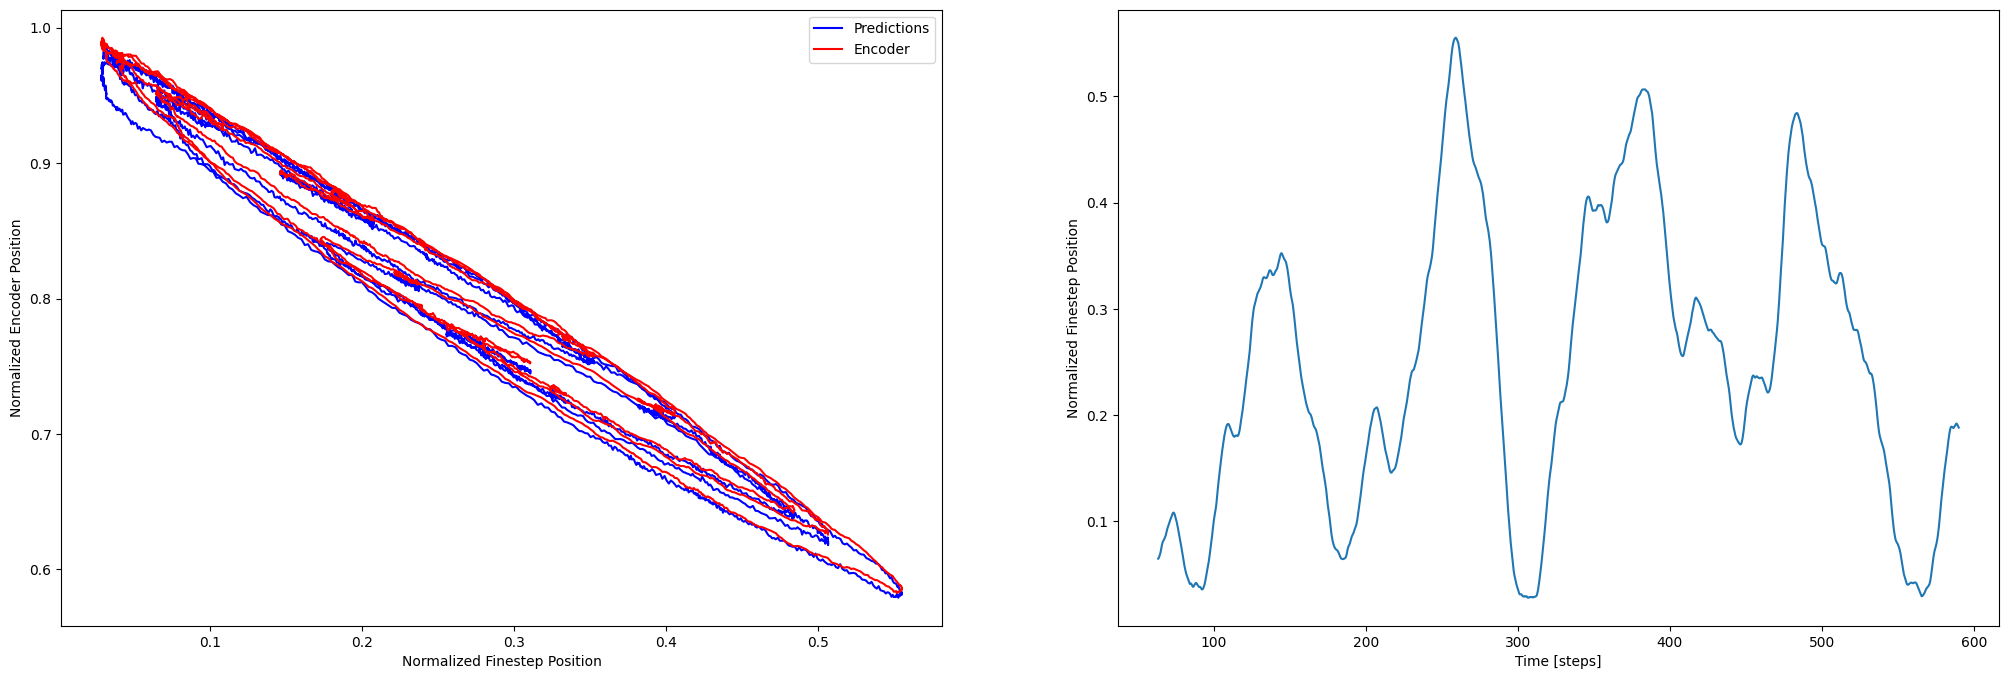

In [41]:
max_samples = 5000
fig, ax = plt.subplots(1, 2, figsize=(25, 8))
#ax[0].plot(test_df['finestep'], -test_df['c_mean'].rolling(8, center=True).mean())
ax[0].plot(test_data[:max_samples]['finestep'], outputs[:max_samples], label='Predictions', color='blue')
ax[0].plot(test_data[:max_samples]['finestep'], test_data[:max_samples]['c_mean'].rolling(8, center=True).mean(), color='red', label='Encoder')
ax[0].legend()
ax[0].set_xlabel('Normalized Finestep Position')
ax[0].set_ylabel('Normalized Encoder Position')
# mark the start and end of the walk
#ax[0].plot(test_df['finestep'].iloc[0], -test_df['c_mean'].iloc[0], 'ro')
#ax[0].plot(test_df['finestep'].iloc[-1], -test_df['c_mean'].iloc[-1], 'ro')
#ax[0].set_xlim(-np.power(2, 15), np.power(2, 15))
#ax[0].set_ylim(max(outputs), min(outputs) - 0.2)

ax[1].plot(test_data[:max_samples]['time'], test_data[:max_samples]['finestep'])
ax[1].set_xlabel('Time [steps]')
ax[1].set_ylabel('Normalized Finestep Position')
#ax[1].set_ylim(-np.power(2, 15), np.power(2, 15))

plt.show()

In [43]:
df = pd.read_csv(r'..\dat\hysteresis\hysteresis_display.csv')
test_df = preprocess_data(df)
test_df.head()
model.eval()
model.to('cuda')
outputs = model(torch.tensor(test_df[columns_input].values, dtype=torch.float32).to('cuda')).cpu().detach().numpy()

mae = np.mean(np.abs(np.array(outputs.flatten()) - test_df['c_mean'].values))
print(f'MAE: {mae}')

MAE: 0.012163252287809713


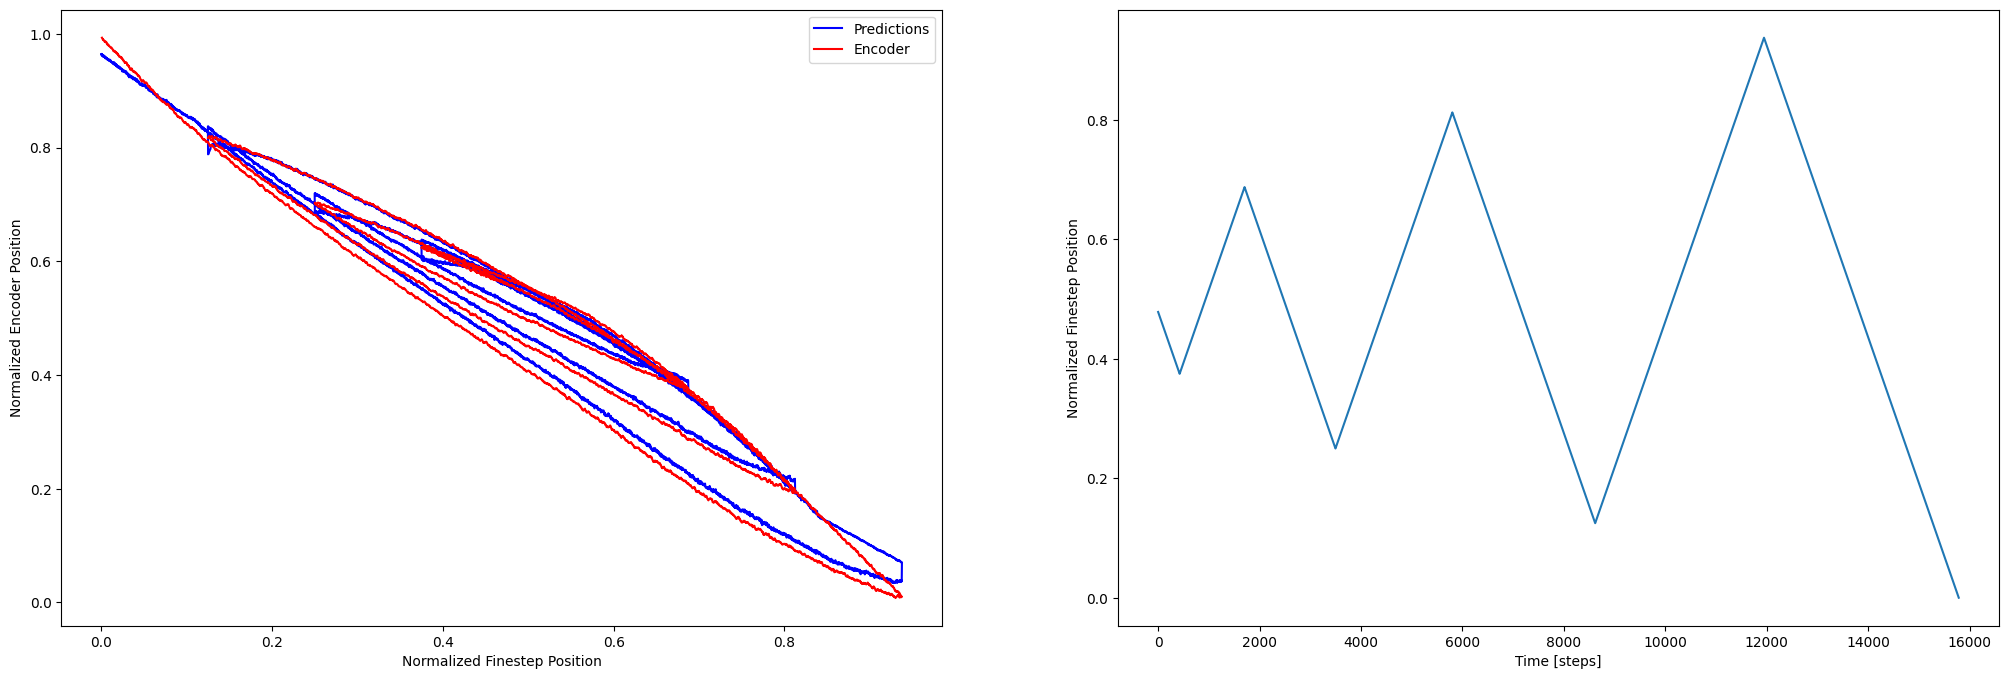

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(25, 8))
outputs_unnorm = np.array(outputs) * (df['counter'].max() - df['counter'].min()) + df['counter'].min()
#ax[0].plot(test_df['finestep'], -test_df['c_mean'].rolling(8, center=True).mean())
ax[0].plot(test_df['finestep'], outputs, label='Predictions', color='blue')
ax[0].plot(test_df['finestep'], test_df['c_mean'].rolling(8, center=True).mean(), color='red', label='Encoder')
ax[0].legend()
ax[0].set_xlabel('Normalized Finestep Position')
ax[0].set_ylabel('Normalized Encoder Position')
# mark the start and end of the walk
#ax[0].plot(test_df['finestep'].iloc[0], -test_df['c_mean'].iloc[0], 'ro')
#ax[0].plot(test_df['finestep'].iloc[-1], -test_df['c_mean'].iloc[-1], 'ro')
#ax[0].set_xlim(-np.power(2, 15), np.power(2, 15))
#ax[0].set_ylim(max(outputs), min(outputs) - 0.2)

ax[1].plot(df['finestep'])
ax[1].set_xlabel('Time [steps]')
ax[1].set_ylabel('Normalized Finestep Position')
#ax[1].set_ylim(-np.power(2, 15), np.power(2, 15))


plt.show()